In [1]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10

from introdl.utils import get_device, load_results, create_CIFAR10_loaders
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, create_image_grid

from sklearn.metrics import accuracy_score

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


# Optimizers and Overfitting

In this notebook we'll explore:
* optimizers that often work better than plain gradient descent
* overfitting -- when the model "memorizes" details of the training set and doesn't generalize well

We're including optimizers and overfitting together because the choice of optimizer and its hyperparameters can reduce overfitting.  

We'll do these things by training a small convolutional network to predict classes for the CIFAR-10 dataset.

## The CIFAR-10 Dataset

The CIFAR-10 dataset is a widely used benchmark dataset in computer vision. It consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images.

The goal of CIFAR-10 is to classify each image into one of the following classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. It is a challenging dataset due to the small image size and the high variability within each class.

To learn more about the CIFAR-10 dataset and access the official webpage, you can visit the following link: [CIFAR-10 Official Website](https://www.cs.toronto.edu/~kriz/cifar.html)

The next cell can be used to view a random sample from the training set.  Run the cell more than once to see different samples.


Files already downloaded and verified


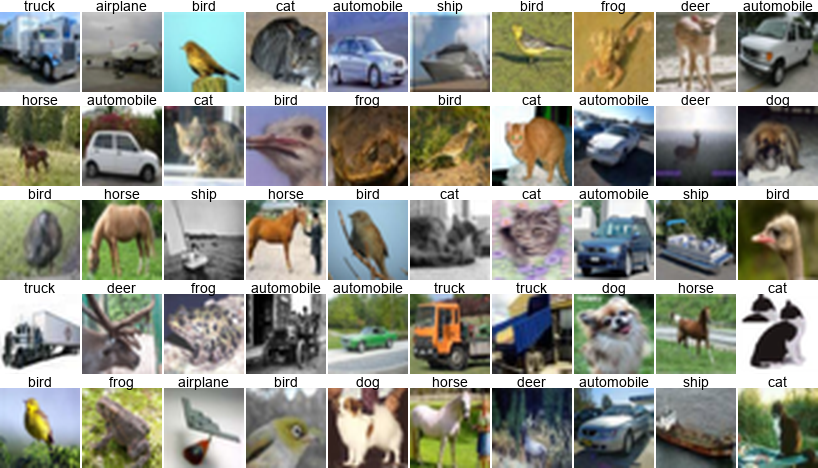

In [2]:
# Load the CIFAR-10 dataset
cifar10_dataset = CIFAR10(root=DATA_PATH, train=True, download=True)

# Example: Display a grid of CIFAR-10 images
create_image_grid(cifar10_dataset, 5, 10, img_size=(80,80), show_labels=True, dark_mode=False)

## A Note on Splitting the Data

In the first couple of lessons we used only **train-test splits** which is fine if you're just doing quick prototyping or if you're using cross-validation on the training set.  If you have a small dataset to begin with, then you may not be able to use a **train-validation-test** split because you simply don't have enough data.

If you have a large dataset you should nearly always use a **train-validation-test** split.  Most of the time in deep learning we need to adjust hyperparameters, like the learning rate and batch size, and we want to try various model architectures and optimizers. If all of these variations are done to the test set then we risk overfitting on that set with no means to assess the performance of our final deep learning pipeline on unseen data.

With a **train-validation-test** split the setup is:
  - The **training set** is used to train the model.
  - The **validation set** is used to tune hyperparameters, select models, and monitor for overfitting.
  - The **test set** is used to evaluate final model performance and should only be used **once**, after model selection and tuning, to assess generalization to unseen data.

Validation sets are critical for:

- **Hyperparameter optimization**: Avoiding overfitting on the test set.
- **Model comparison**: Selecting the best-performing model based on validation metrics.
- **Early stopping**: Using validation loss to decide when to stop training.

If you use only a test set for hyperparameter tuning and model selection, you risk overfitting to the test data, making the test results less meaningful. Using a validation set ensures the test set remains untouched for final performance evaluation.

If you just took a machine learning class, you probably learned about cross-validation.  Cross-validation and its variations are terrific, but they're often not feasible in the context of deep learning due to the computational demands and typical size of deep learning datasets.  As long as we have enough data and randomly split it, then we should be able to get reliable performance evaluation without cross-validation.

In this notebook, we'll use a **train-validation-test** split.  Since `torchvision` datasets come with test-train splits, we'll further split the training set into a new training set and a validation set.  The function in the next section shows how to do this with the CIFAR-10 dataset.


  



## DataLoaders and Splitting CIFAR-10

We'll use a fairly typical 90%/10% split of the original training set to produce training and validation sets. After we've settled on training techniques and a better model architecture in Lesson 4, we'll use the test dataset to see how our final model performs.

We setup a function to produce the DataLoaders so we can later add various image augmentations to the transforms (you'll see what this means later).  The function can be imported from `introdl.utils` for  convenience in other notebooks. We'll look at the function a bit in the video accompanying this notebook or you can look at the source code yourself.

In [ ]:
# run this cell to create the dataloaders
# note that we set data_dir in the imports cell at the top of the notebook

train_loader, valid_loader, test_loader= create_CIFAR10_loaders(data_dir=DATA_PATH, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Create a simple CNN

Here we create a simple CNN similar to the one you created in Lesson 2.  This won't give terrific performance on the CIFAR-10 dataset, but it will allow us to explore various training techniques include using different optimizers, learning rate schedulers, and data augmentation.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Establish a baseline - Train with SGD

First we'll train our model with Stochastic Gradient Descent (gradient descent with mini-batches).  The best learning rate varies by model and dataset.  It's not a bad idea to start with a larger rate like 0.1 and then decrease it exponentially like 0.01, 0.001, etc.  An optimal learning rate involves finding a balance between being sufficiently large and small. It should be set to a value that allows our algorithm to converge quickly without being so large that it causes erratic behavior and prevents reaching a minimum.

Choosing a good learning rate can involve a bit of trial and error, but with more advanced optimizers it's usually less of an issue.  It's also possible to train a few batches with a varying learning rates to get a range of good values (look up PyTorch learning rate finder, or ask an AI).  The following "cartoon" demonstrating what you're seeking for a good learning rate is widely circulating on the internet.  I don't know the original source!

<img src="./pictures/learning_rates.jpg" alt="Learning Rates" style="width: 400px;"/>

Below, we'll train three times with learning rates 0.1, 0.01, and 0.001 for just five epochs in each case.  After which we'll select a learning rate and train for 20 epochs.  Think of this as a rudimentary grid search for the best learning rate.


In [5]:
# this cell takes several minutes to run, you can run the next cell if you just want to see the results from a previous run
loss_func = nn.CrossEntropyLoss()

device = get_device()
print(device)

epochs = 5
score_funcs = {'ACC':accuracy_score}

for lr in [0.1, 0.01, 0.001]:
    model = SimpleCNN()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    ckpt_file = MODELS_PATH / f'L03_CIFAR10_SimpleCNN_SGD_lr{lr}.pt'
    print(f'\nLearning rate: {lr}')
    results = train_network(model,
                  loss_func,
                  train_loader,
                  device=device,
                  val_loader=valid_loader,
                  epochs = epochs,
                  optimizer = optimizer,
                  score_funcs = {'ACC':accuracy_score},
                  checkpoint_file = ckpt_file)
    print('\n')
    display(results)

    print('-------------------------------------------------\n')

cuda

Learning rate: 0.1


Epoch: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it, train_loss=0.599, val_loss=0.91] 

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,10.652918,1.538482,1.232478,0.445850,0.5671
1,1,12.477775,1.088306,1.073645,0.612950,0.6277
2,2,13.802110,0.892204,0.965663,0.685700,0.6597
3,3,15.091122,0.742749,0.893360,0.737675,0.6908
4,4,16.384889,0.599387,0.910151,0.791375,0.6980


-------------------------------------------------


Learning rate: 0.01


Epoch: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it, train_loss=1.15, val_loss=1.14]

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,1.260330,1.895718,1.611399,0.327325,0.4250
1,1,2.521338,1.502704,1.401689,0.465125,0.4999
2,2,3.785791,1.341647,1.272330,0.518425,0.5534
3,3,5.027089,1.232264,1.205343,0.563175,0.5742
4,4,6.604687,1.145207,1.138967,0.597075,0.6033


-------------------------------------------------


Learning rate: 0.001


Epoch: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, train_loss=1.8, val_loss=1.77] 

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,1.529328,2.254137,2.193846,0.200575,0.2451
1,1,3.029478,2.121056,2.046713,0.270350,0.2900
2,2,4.471319,1.985640,1.928512,0.309600,0.3229
3,3,5.897639,1.879604,1.836009,0.346450,0.3540
4,4,7.314357,1.802615,1.768876,0.369900,0.3749


-------------------------------------------------



In [6]:
# if you want to display the results of the training of the model with different learning rates without running the training, run this cell

for lr in [0.1, 0.01, 0.001]:
    chkpt_file = MODELS_PATH / f'L03_CIFAR10_SimpleCNN_SGD_lr{lr}.pt'
    print(f'\nLearning rate: {lr}')
    results = load_results(chkpt_file)
    print('\n')
    display(results)
    print('-------------------------------------------------\n')


Learning rate: 0.1




,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,10.652918,1.538482,1.232478,0.445850,0.5671
1,1,12.477775,1.088306,1.073645,0.612950,0.6277
2,2,13.802110,0.892204,0.965663,0.685700,0.6597
3,3,15.091122,0.742749,0.893360,0.737675,0.6908
4,4,16.384889,0.599387,0.910151,0.791375,0.6980


-------------------------------------------------


Learning rate: 0.01




,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,1.260330,1.895718,1.611399,0.327325,0.4250
1,1,2.521338,1.502704,1.401689,0.465125,0.4999
2,2,3.785791,1.341647,1.272330,0.518425,0.5534
3,3,5.027089,1.232264,1.205343,0.563175,0.5742
4,4,6.604687,1.145207,1.138967,0.597075,0.6033


-------------------------------------------------


Learning rate: 0.001




,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,1.529328,2.254137,2.193846,0.200575,0.2451
1,1,3.029478,2.121056,2.046713,0.270350,0.2900
2,2,4.471319,1.985640,1.928512,0.309600,0.3229
3,3,5.897639,1.879604,1.836009,0.346450,0.3540
4,4,7.314357,1.802615,1.768876,0.369900,0.3749


-------------------------------------------------



Let's compare the training results for the three learning rates:
* $\lambda = 0.1$ - we're seeing a growing gap between the training and test metrics for both loss and accuracy which is a sign of overfitting.  Further training would only exaggerate this trend.  Note that the test loss was even increasing on the last epoch.
* $\lambda = 0.01$ - it's too soon to tell if we're overfitting here.  
* $\lambda = 0.001$ - this is working, but convergence is slow.

Let's resume training with $\lambda = 0.01$ and train for 25 more epochs.  You can use a checkpoint file to resume training by passing it to `train_network` as the `resume_file` variable.

In [7]:
model = SimpleCNN() # create a new instance, will be overwritten by the loaded model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

device = get_device()
print(device)

resume_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_SGD_lr0.01.pt'
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_SGD_lr0.01_full.pt'
epochs = 25

score_funcs = {'ACC':accuracy_score}

train_network(model,
              loss_func,
              train_loader,
              device=device,
              val_loader=valid_loader,
              epochs = epochs,
              optimizer = optimizer,
              score_funcs = score_funcs,
              checkpoint_file=ckpt_file,
              resume_file=resume_file);

cuda


Epoch: 100%|██████████| 25/25 [00:45<00:00,  1.83s/it, train_loss=0.14, val_loss=1.21]  


Instead of viewing the raw values of the metrics, let's skip right to the plots.

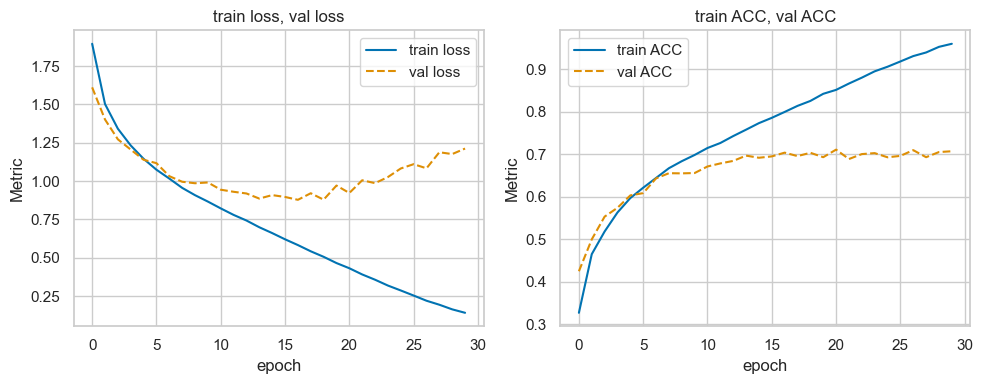

In [8]:
results = load_results(MODELS_PATH / 'L03_CIFAR10_SimpleCNN_SGD_lr0.01_full.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

After epoch 10 the validation loss is flat for a while and then starts increasing.  The validation accuracy doesn't increase much after epoch 10.  Training for too long often leads to overfitting as a complex enough model will "memorize" features in the training set and won't generalize well to unseen data.  We should stop the training around epoch 10.  We can also try other approaches for reducing overfitting including regularization and data augmentation.

Before we focus more on preventing overfitting, we're going to look at more modern optimizers than Stochastic Gradient Descent.  Some of these optimizers include features to help reduce overfitting.


## The Adam Optimizer

The Adam optimizer is an extension of the Stochastic Gradient Descent (SGD) algorithm that incorporates adaptive learning rates and momentum. It combines the benefits of two other popular optimization algorithms, AdaGrad and RMSProp.

Intuitively, the Adam optimizer adjusts the learning rate for each parameter individually based on the historical gradients. It keeps track of the first and second moments of the gradients to estimate the adaptive learning rates. This allows the optimizer to adaptively scale the learning rates for different parameters, which can be beneficial when dealing with sparse gradients or noisy data.  

A learning rate of $0.001$ is a good default choice for Adam.  Convergence is less sensitive to the choice of learning rate here since Adam adapts the learning rates.  The performance does change some changes in this hyperparameter and later we'll see that using a learning rate scheduler can also help.

Let's try a couple of different learning rates with Adam.  We tried $\lambda = 0.1$ and $\lambda = 0.01$ and the loss functions didn't decrease at all which shows those learning rates are too big.  We won't show those results.  Below we'll try $\lambda = 0.001$ and $\lambda = 0.0001.$


In [9]:
# this cell takes several minutes to run, you can run the next cell if you just want to see the results from a previous run
loss_func = nn.CrossEntropyLoss()

device = get_device()
print(device)

epochs = 5
score_funcs = {'ACC':accuracy_score}

for lr in [0.001, 0.0001]:
    model = SimpleCNN()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ckpt_file = MODELS_PATH / f'L03_CIFAR10_SimpleCNN_Adam_lr{lr}.pt'
    print(f'\nLearning rate: {lr}')
    results = train_network(model,
                  loss_func,
                  train_loader,
                  device=device,
                  val_loader=valid_loader,
                  epochs = epochs,
                  optimizer = optimizer,
                  score_funcs = {'ACC':accuracy_score},
                  checkpoint_file = ckpt_file)
    print('\n')
    display(results)

    print('-------------------------------------------------\n')

cuda

Learning rate: 0.001


Epoch: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it, train_loss=0.632, val_loss=0.881]

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,1.512524,1.367609,1.076789,0.512975,0.6219
1,1,3.063418,0.983368,0.949561,0.656075,0.6662
2,2,4.567195,0.840243,0.875090,0.705425,0.6935
3,3,6.091857,0.736107,0.878182,0.740325,0.6950
4,4,7.609296,0.632127,0.881004,0.778875,0.7040


-------------------------------------------------


Learning rate: 0.0001


Epoch: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it, train_loss=1.11, val_loss=1.12]

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,1.501472,1.675879,1.448474,0.409325,0.4911
1,1,3.025430,1.361185,1.310730,0.518775,0.5330
2,2,4.538291,1.244277,1.216040,0.562475,0.5747
3,3,6.054396,1.164632,1.162820,0.591625,0.5937
4,4,7.500513,1.105916,1.117254,0.613975,0.6050


-------------------------------------------------



Notice that with both of these learning rates we're getting convergence much quicker than we did with SGD.  Our validation accuracy maxed out around 70% with SGD as well, but it took more epochs.  Adam showing signs of overfitting already with $\lambda = 0.001$.  It will likely overfit if we train for more epochs with $\lambda = 0.0001$ as well.  Let's try adding 15 more epochs to see what happens.

In [10]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Stochastic gradient descent

device = get_device()
print(device)

resume_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_Adam_lr0.0001.pt'
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_Adam_lr0.0001_full.pt'
epochs = 15

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file,
                resume_file = resume_file)

cuda


Epoch: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it, train_loss=0.659, val_loss=0.895]


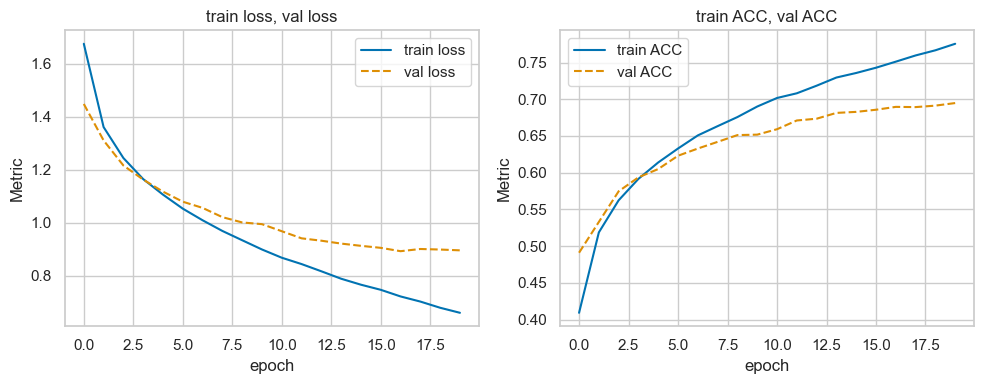

In [11]:
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_Adam_lr0.0001_full.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

# you can try the following code for an interactive version of the training metrics plot
# plot_training_metrics_widget(results)

Even with the small learning rate of $\lambda=0.0001$ we're seeing overfitting.  Moreover, with this learning rate we still haven't reached the validation accuracy around 70% that we saw in 5 epochs with $\lambda = 0.001.$  Further below we'll plot these results against the SGD results to see how the optimizers compare.

## AdamW Optimizer

AdamW is a modification of the Adam optimizer that introduces weight decay regularization. Weight decay is a technique used to prevent overfitting by adding a penalty term to the loss function that discourages large parameter values. It helps to control the complexity of the model and improve generalization.  This is essentially the same kind of penalty term that was used in the machine learning class for ridge regression.

In AdamW, the weight decay term is applied directly to the weight updates during optimization. This means that the weight decay is decoupled from the adaptive learning rate mechanism of Adam. By decoupling weight decay from the adaptive learning rate, AdamW avoids the potential issue of the weight decay term interfering with the adaptive learning rate behavior.

While there are several parameters that can be adjusted.  Using the default learning rate `lr=0.001` works well.  We can experiment with the weight decay parameter, `weight_decay = 0.01`.  Increasing this from it's default value of 0.01 can increase the regularization to prevent overfitting.  The challenge usually is to make `weight_decay` large enough to reduce overfitting while not reducing the overall accuracy.

Let's try `AdamW` with its default values for 10 epochs:

In [12]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_defaults.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

cuda


Epoch: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it, train_loss=0.188, val_loss=1.23]


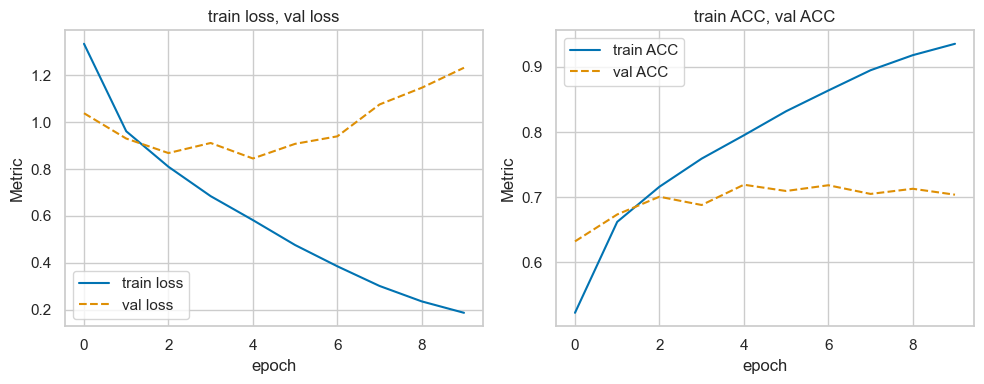

In [13]:
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_defaults.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

# you can try the following code for an interactive version of the training metrics plot
# plot_training_metrics_widget(results)

Wow, that's classic overfitting!  The training loss continues to decrease while the validation loss actually starts increasing.  The network is "memorizing" the training data and failing to generalize to the test data.  The performance of AdamW with its default parameters is worse than that of the original Adam.

### Increasing the regularization

Let's try increasing the weight_decay parameter to increase the regularization to see if it will reduce overfitting.  The larger value of weight_decay should act as a further deterrent to large parameter values which means the network has to distribute its learning across many parameter values instead of focusing on just a few.  

This time we'll train for 15 epochs so we can better see how the metric for training and testing compare.

In [14]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),weight_decay=0.5)

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_wd.pt'
epochs = 15

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

cuda


Epoch: 100%|██████████| 15/15 [00:28<00:00,  1.88s/it, train_loss=0.618, val_loss=0.875]


From the training plots we can see that overfitting hasn't been completely eliminated, but it has been lessened with the increased `weight_decay` parameter.

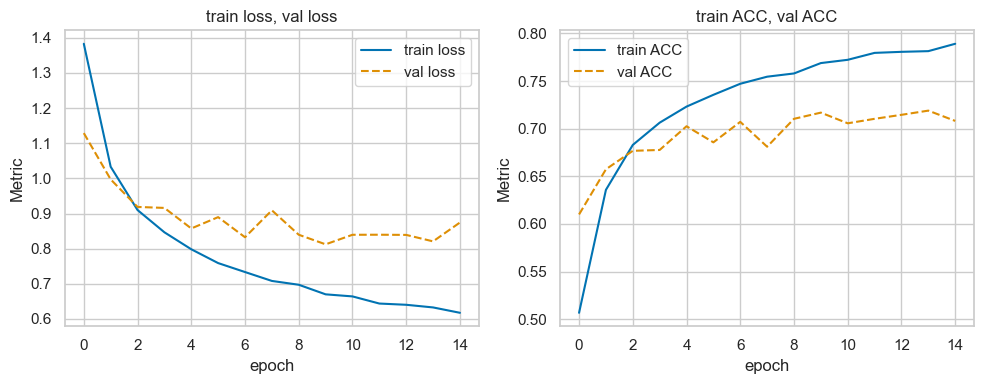

In [15]:
ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_wd.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

# you can try the following code for an interactive version of the training metrics plot
# plot_training_metrics_widget(results)

## Compare the Optimizers

We can plot the test metrics vs epoch for SGD, Adam, and AdamW with increased weight decay to see how they compare:

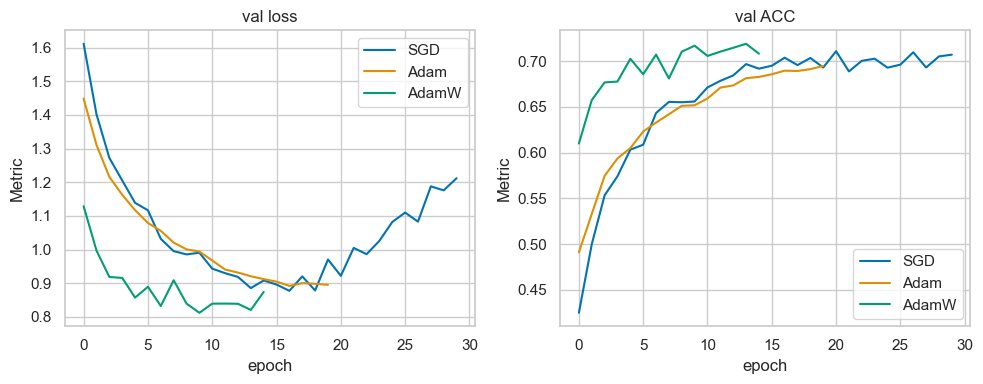

In [16]:

AdamW  = load_results(MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_wd.pt')

Adam = load_results(MODELS_PATH / 'L03_CIFAR10_SimpleCNN_Adam_lr0.0001_full.pt')

ckpt_file = MODELS_PATH /'L03_CIFAR10_SimpleCNN_SGD_lr0.01_full.pt'
SGD = load_results(ckpt_file)

plot_training_metrics([SGD, Adam, AdamW], [['val loss'], ['val ACC']],df_labels=['SGD', 'Adam', 'AdamW'])

AdamW with the increased weight decay parameter seems to perform the best.  It had less overfitting and converges in fewer epochs than the other optimizers.